# Sentiment Analysis on Unlabeled Data

In this notebook, I use basic techniques to do sentiment analysis on unlabeled data extracted from ESPN. 

<b>Outline:</b>

<li>Extract data from Flipboard from their Sports, Technology, Business, Science and Politics subpages</li>
<li>Preprocess and clean the data using some standard techniques</li>
<li>Text Parsing</li>

I first scrape a news website to extract data then clean up the data using some standard preprocessing techniques and then use `nltk` and `spacy` libraries to categorize data. 

__Load the libraries__

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

## Get data

Website scraper to create data

In [60]:
seed_urls = ['https://flipboard.com/topic/sports',
             'https://flipboard.com/topic/technology',
             'https://flipboard.com/topic/business',
             'https://flipboard.com/topic/science',
             'https://flipboard.com/topic/politics']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        print(url)
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        #return soup
        for headline, article in zip(soup.find_all('h1', class_=["post__title article-text--title--large"]),
                                                     soup.find_all('p', class_=["post__excerpt"])):
            print(headline, article)
            print({'news_headline': headline.find('a', attrs={"data-test-id": "home-feeds"}).string,
                          'news_article': article.find('a', attrs={"class": "article-text--body"}).string,
                          'news_category': news_category})
        """
        news_articles = [{'news_headline': headline.find('a', attrs={"data-test-id": "home-feeds"}).string,
                          'news_article': article.find('a', attrs={"class": "article-text--body internal-link"}).string,
                          'news_category': news_category}
                        
                        for headline, article in zip(soup.find_all('h1', class_=["post__title article-text--title--large"]),
                                                     soup.find_all('p', class_=["post__excerpt"]))
                        
                        ]
        
        news_data.extend(news_articles)
        #print(news_data)
    df = pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df
    """

In [79]:
seed_urls = ['https://flipboard.com/topic/sports',
             'https://flipboard.com/topic/technology',
             'https://flipboard.com/topic/business',
             'https://flipboard.com/topic/science',
             'https://flipboard.com/topic/politics']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        print('Extracting data from...', url)
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('a', attrs={"data-test-id": "home-feeds"}).string,
                          'news_article': article.find('a', attrs={"class": "article-text--body"}).string,
                          'news_category': news_category}
                        
                        for headline, article in zip(soup.find_all('h1', class_=["post__title article-text--title--large"]),
                                                     soup.find_all('p', class_=["post__excerpt"]))]
        news_data.extend(news_articles)
    
    df = pd.DataFrame(news_data)
    df[['news_headline', 'news_article', 'news_category']]
    return df

In [80]:
news_df = build_dataset(seed_urls)
news_df

Extracting data from... https://flipboard.com/topic/sports
Extracting data from... https://flipboard.com/topic/technology
Extracting data from... https://flipboard.com/topic/business
Extracting data from... https://flipboard.com/topic/science
Extracting data from... https://flipboard.com/topic/politics


,news_headline,news_article,news_category
0,Lady Gaga shocks fans by sharing a very intim...,Lady Gaga is certainly not hiding her love fo...,sports
1,Report: Buffalo Bills to meet with tight end ...,Within hours of Greg Olsen being released by ...,sports
2,"Report: Celtics, Rockets Discussing Major NBA...",This week will be hectic in the NBA. The leag...,sports
3,NBA trade deadline rumors: Andre Iguodala pre...,The Feb. 6 NBA trade deadline is fast approac...,sports
4,Stephen A. Smith blasts Kyle Shanahan after 4...,Kyle Shanahan abandoned the run when the 49er...,sports
...,...,...,...
144,Schiff Warns of Acquittal Precedent: Trump ‘C...,"Representative Adam Schiff (D., Calif.) said ...",politics
145,Iowa Democratic presidential caucus is too ea...,The first-in-the-nation Democratic presidenti...,politics
146,President Trump to deliver State of the Union...,The lingering impeachment trial looms over th...,politics
147,Iowa caucus will offer assemblies in Spanish ...,The Iowa caucuses are set up in a way that dis...,politics


In [81]:
news_df.news_category.value_counts()

technology    30
politics      30
science       30
business      30
sports        29
Name: news_category, dtype: int64

## Text Preprocessing

Preprocess the text by removing html tags, common stopwords, etc.

In [83]:
import spacy
import en_core_web_lg
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from contractions import CONTRACTION_MAP
import unicodedata

nlp = en_core_web_lg.load()
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
# Want to keep negative stop words for sentiment analysis
stopword_list.remove('no')
stopword_list.remove('not')

In [84]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>text text text</h2></html>')

'text text text'

In [85]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('some accented letters â î or ô')

'some accented letters a i or o'

In [86]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
            if contraction_mapping.get(match) \
            else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("y'all I've don't I'd we're")

'you all I have do not I would we are'

In [87]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("S0me sp3ci@l c#@4@c|3rs *&)@&)@#&", remove_digits=True)

'Sme spcil ccrs '

In [101]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text(str(news_df.news_article[0]))

'  Lady Gaga be certainly not hide her love for new beau Michael Polansky , whom she just go public with on Sunday at Super Bowl LIV in Miami after …'

In [102]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

remove_stopwords(str(news_df.news_article[0]))

'Lady Gaga certainly not hiding love new beau Michael Polansky , went public Sunday Super Bowl LIV Miami …'

In [103]:
def normalize_corpus(corpus, html_stripping=True, accented_char_removal=True, contraction_expansion=True, 
                    text_lower_case=True, text_lemmatization=True, special_char_removal=True, stopword_removal=True,
                    remove_digits=True):
    normalized_corpus = []
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions
        if contraction_expansion:
            doc = expand_contractions(doc)
        # turn into lowercase
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ', doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and/or digits
        if special_char_removal:
            # insert spaces between special characters to isolate them
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)
        # remove extra whitespaces
        doc = re.sub(' _', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
    
    return normalized_corpus

In [104]:
# combine news headline and article text into one doc
news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]

# pre-process text
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])

news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'full_text': ' Report: Buffalo Bills to meet with tight end Greg Olsen.  Within hours of Greg Olsen being released by the Carolina Panthers, the former Pro Bowl tight end has a visit scheduled with the Buffalo Bills, …',
 'clean_text': 'report buffalo bill meet tight end greg olsen within hour greg olsen release carolina panthers former pro bowl tight end visit schedule buffalo bill'}

## Text Parsing

Since the data are unlabeled we need to get creative to understand the words and their meanings.  What we do know is that language is not just a random collection of words and phrases.  There is structure behind language and syntax governs the ordering of these words.  We can use this information to try to understand langugage. 

There are some ways of accomplishing this: 
<ul>Part of Speech (POS) Tagging</ul>
<ul>Shallow Parsing or Chunking</ul>
<ul>Constituency Parsing</ul>
<ul>Dependency Parsing</ul>

### POS Tagging

Speech has specific lexical categories to which words can be assigned to based on their syntactic context and role. Words can fall into major categories such as: Noun, Verb, Adjective, Adverb, Prepositions, etc. Furthermore, a category can be further divided into its subcategories.  For example, Noun can be subdivided into <i>singular nouns</i>, <i>plural nouns</i> etc.

The goal behind POS is to classify and label words into categories and subcategories so that we can further use them to perform specific analyses such as narrowing them down upon nouns and finding the ones that are the most prominent, for word disambiguation and grammar analysis. 

This website [https://parts-of-speech.info/] helps with visualizing POS tagging.

Here, I use `nltk`and `spacey` for POS tagging. Both of these use the <i>Penn Treebank notation:</i> https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/data/Penn-Treebank-Tagset.pdf

In [105]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aksin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [154]:
# pre-process, but don't lowercase or lemmatize to get POS context
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, text_lemmatization=False, special_char_removal=False)

# demo for POS tagging
sentence = str(news_df.iloc[0].news_headline)
sentence_nlp = nlp(sentence)

# POS tagging with spacy
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
df_spacy_pos_tagged = pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
df_nltk_pos_tagged = pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])


Let's see how the `spacy` and `nltk` libraries use POS to tag words. 

In [155]:
sentence

' Lady Gaga shocks fans by sharing a very intimate photo with Michael Polansky'

In [156]:
df_spacy_pos_tagged

,Word,POS tag,Tag type
0,,_SP,SPACE
1,Lady,NNP,PROPN
2,Gaga,NNP,PROPN
3,shocks,VBZ,VERB
4,fans,NNS,NOUN
5,by,IN,ADP
6,sharing,VBG,VERB
7,a,DT,DET
8,very,RB,ADV
9,intimate,JJ,ADJ


In [157]:
df_nltk_pos_tagged

,Word,POS tag
0,Lady,NNP
1,Gaga,NNP
2,shocks,NNS
3,fans,NNS
4,by,IN
5,sharing,VBG
6,a,DT
7,very,RB
8,intimate,JJ
9,photo,NN


There are some clear differences between the two, but it's hard to tell which of `nltk` and `spacy` is performing better 

### Shallow Parsing (Chunking)

We can use some additional syntactical knowledge about language to our advantage. A sentence can be broken down into phrases where one word acts as the focal piece of that phrase.  There are 5 major categories: 
<ul><b>Noun Phrase: </b>These are phrases where noun acts as the head word</ul>
<ul><b>Verb Phrase: </b>Similar to Noun Phrase but the verb acts as the head word</ul>
<ul><b>Adjective Phrase: </b>Adjective is the head word and works to qualify nouns and pronouns</ul>
<ul><b>Adverb Phrase: </b>Adverb is the head word and modifies verbs or adverbs themselves</ul>
<ul><b>Prepositional Phrase: </b>Prepositions are the head words</ul>

Shallow parsing basically breaks a sentence down into its smallest possible constituents (POS tagging on tokens) and groups them together into higher-level phrases (parsing). 

Here, we'll use the `conll2000` corpus from `nltk` to train our model

In [126]:
nltk.download('conll2000')

[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\aksin\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!


True

In [132]:
# using nltk conll2000 corpus to train the shallow parser model
from nltk.corpus import conll2000

data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:]

print(len(train_data), len(test_data))
print(train_data[0])

10900 48
(S
  (NP Confidence/NN)
  (PP in/IN)
  (NP the/DT pound/NN)
  (VP is/VBZ widely/RB expected/VBN to/TO take/VB)
  (NP another/DT sharp/JJ dive/NN)
  if/IN
  (NP trade/NN figures/NNS)
  (PP for/IN)
  (NP September/NNP)
  ,/,
  due/JJ
  (PP for/IN)
  (NP release/NN)
  (NP tomorrow/NN)
  ,/,
  (VP fail/VB to/TO show/VB)
  (NP a/DT substantial/JJ improvement/NN)
  (PP from/IN)
  (NP July/NNP and/CC August/NNP)
  (NP 's/POS near-record/JJ deficits/NNS)
  ./.)


The example above shows that the tokens are POS-tagged and combinations of words are further grouped into phrases.  This is not super easy to visualize, but if you spend some time drawing it out, it starts to make sense. We'll use this data set to train our shallow parser model. 

In order to do so, we will also use two chunking utility functions:
<ul><i>tree2conlltags</i> will get us a triplet of (word, tag, chunk tag) for each token</ul>
<ul><i>conlltags2tree</i> will generate a parse tree for these token triples</ul>

In the example below, we can see that the tree2conlltags takes the pre-tagged sentence and turns it into a chunk. Note that the `tree2conlltags` uses the IOB format, which stands for <i>I</i>nside, <i>O</i>utside, and <i>B</i>eginning and indicates where the token is located inside the chunk. The 'O' token indicates that the token does not belong to any chunk. 

In the sentence above, look at the verb phrase (noted VP) "is widely expected to take" where 'is', 'widely', 'expected', 'to' and 'take' are POS-tagged as 'VBZ', 'RB', 'VBN', 'TO', and 'VB', respectively. When chunked using `tree2conlltags`, the POS tags remain the same, but the chunk tags are now 'B-VP', 'I-VP', 'I-VP', 'I-VP' and 'I-VP', respectively, which should make sense. commas and 'due' are outside the word phrases and are therefore chunk-labeled as 'O'. 

In [134]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[0])
wtc

[('Confidence', 'NN', 'B-NP'),
 ('in', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('pound', 'NN', 'I-NP'),
 ('is', 'VBZ', 'B-VP'),
 ('widely', 'RB', 'I-VP'),
 ('expected', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('take', 'VB', 'I-VP'),
 ('another', 'DT', 'B-NP'),
 ('sharp', 'JJ', 'I-NP'),
 ('dive', 'NN', 'I-NP'),
 ('if', 'IN', 'O'),
 ('trade', 'NN', 'B-NP'),
 ('figures', 'NNS', 'I-NP'),
 ('for', 'IN', 'B-PP'),
 ('September', 'NNP', 'B-NP'),
 (',', ',', 'O'),
 ('due', 'JJ', 'O'),
 ('for', 'IN', 'B-PP'),
 ('release', 'NN', 'B-NP'),
 ('tomorrow', 'NN', 'B-NP'),
 (',', ',', 'O'),
 ('fail', 'VB', 'B-VP'),
 ('to', 'TO', 'I-VP'),
 ('show', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('substantial', 'JJ', 'I-NP'),
 ('improvement', 'NN', 'I-NP'),
 ('from', 'IN', 'B-PP'),
 ('July', 'NNP', 'B-NP'),
 ('and', 'CC', 'I-NP'),
 ('August', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('near-record', 'JJ', 'I-NP'),
 ('deficits', 'NNS', 'I-NP'),
 ('.', '.', 'O')]

Now comes the fun part. Remember that the goal is to train the model to predict chunk tags based on POS tags because we already tagged our news corpus with POS tags. Now we want to shallow parse it. In order to do that, we'll first define a function `conll_tags_chunks` to extract the POS tags and chunk tags from the tagged sentences.  Then we want to predict the chunk tags based on the POS tags. This is where the next function `combined_tagger`comes in. 

This function will train our taggers, which in this case will be unigram and bigram taggers.  Basically: the `UnigramTagger` class from `nltk` assigns the tag that is the most likely tag for that token's type.  For example, it'll assign the tag 'JJ' to any occurrence of the word 'frequent' because 'frequent' is used more often as an adjective (e.g., 'a frequent visitor') more often that it is used as a very (e.g., 'I frequent this climbing gym'). However, before a `UnigramTagger` can be used to tag data, it needs to be trained on a <i>training corpus</i>, which the tagger then uses to determine the tags that are the most common for each word. 

The `BigramTagger` is a bit more complex because in addition to considering the token's type, it also considers the POS tags of the preceding token.  The `TrigramTagger` would consider the POS tags of two preceding tokens, etc. To decide which tag to assign to a token, the `BigramTagger` first constructs a <i>context</i> for the token. This consists of the token's type, along with the POS tags of the preceding token.  It then picks the tag that is most likely for that context. 

We'll define a class `NGramTagChunker` that will take tagged sentences as training input, get their POS and chunk tags and then train a `BigramTagger` with a  `UnigramTagger` as the backoff tagger.  The `parse` function will perform shallow parsing on new sentences. 

In [135]:
# extract POS and chunk tags from sentences with chunked annotations
def conll_tags_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]

# function to train multiple taggers
def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff

In [139]:
%%time

from nltk.tag import UnigramTagger, BigramTagger, TrigramTagger
from nltk.chunk import ChunkParserI

# chunker class
class NGramTagChunker(ChunkParserI):
    def __init__(self, train_sentences, tagger_classes=[UnigramTagger, BigramTagger]):
        # get the POS and chunk tags using our function above
        train_sent_tags = conll_tags_chunks(train_sentences)
        # train chunk tagger from POS tags
        self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)
    
    def parse(self, tagged_sentence):
        if not tagged_sentence:
            return None
        # get POS tags from our tagged sentence
        pos_tags = [tag for word, tag in tagged_sentence]
        # Get chunk tags from the trained taggers
        chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
        chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
        # Combine token, pos tag and chunk tags
        wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                       in zip(tagged_sentence, chunk_tags)]
        return conlltags2tree(wpc_tags)
    
# train chunker model
ntc = NGramTagChunker(train_data)

# evaluate chunker model performance
print('Performance on training data:\n', ntc.evaluate(train_data))
print()
print('Performance on test data:\n', ntc.evaluate(test_data))
        

Performance on training data:
 ChunkParse score:
    IOB Accuracy:  89.4%%
    Precision:     80.9%%
    Recall:        86.2%%
    F-Measure:     83.5%%

Performance on test data:
 ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%
Wall time: 6.96 s


Not bad. We get 90% accuracy on the test set. Now let's see how the trained model chunks our news corpus headline

In [158]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP Lady/NNP Gaga/NNP shocks/NNS fans/NNS)
  (PP by/IN)
  (VP sharing/VBG)
  (NP a/DT)
  very/RB
  (NP intimate/JJ photo/NN)
  (PP with/IN)
  (NP Michael/NNP Polansky/NNP))


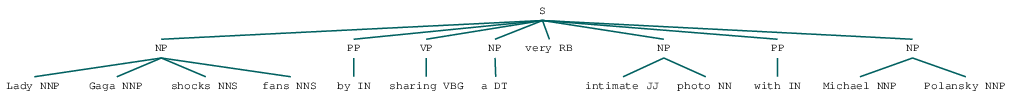

In [159]:
from IPython.display import display

os.environ['PATH'] = os.environ['PATH'] + ";C:\\Program Files\\gs\\gs9.50\\bin\\"
display(chunk_tree)

### Constituency Parsing

This concept is based on the intuition that sentences have internal structure and hierarchy. Each word belongs to a specific lexical category and forms the head word of different phrases. These phrases are formed based on rules called <i>phrase structure rules.</i>  

I won't go into much detail here, but a great visualization tool is available here: https://demo.allennlp.org/constituency-parsing.  

We'll use the `StanfordParser` from `nltk` to generate parse trees

In [161]:
java_path = r'C:\Program Files\Java\jdk1.8.0_221\bin\java.exe'
os.environ['JAVAHOME'] = java_path

from nltk.parse.stanford import StanfordParser

scp = StanfordParser(path_to_jar='stanford-parser-full-2018-10-17/stanford-parser.jar', 
                     path_to_models_jar='stanford-parser-full-2018-10-17/stanford-parser-3.9.2-models.jar')
result = list(scp.raw_parse(sentence))
print(result[0])

C:\Users\aksin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The StanfordParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPParser instead.
  import sys


(ROOT
  (S
    (NP (NNP Lady) (NNP Gaga))
    (VP
      (VBZ shocks)
      (NP (NNS fans))
      (PP
        (IN by)
        (S
          (VP
            (VBG sharing)
            (NP
              (NP (DT a) (ADJP (RB very) (JJ intimate)) (NN photo))
              (PP (IN with) (NP (NNP Michael) (NNP Polansky))))))))))


The visualization below sould help

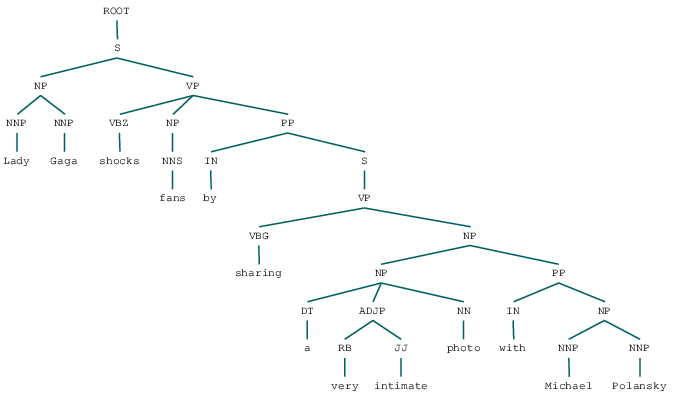

In [163]:
from IPython.display import display
display(result[0])

### Dependency Parsing

The concept here is that all words except for one have some relationship or dependency on other words in the sentence. The verb istypically the root of the sentence in a majority of the cases. All other words are directly or indirectly linked to the root verb using links aka dependencies. <a href='https://universaldependencies.org/u/dep/index.html'>More info here</a>

In [164]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n-------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_,
                                  w_type = token.dep_,
                                  left=[t.orth_ for t in token.lefts],
                                  right=[t.orth_ for t in token.rights]))

[]<--- []--->[]
-------
[' ']<---Lady[compound]--->[]
-------
['Lady']<---Gaga[nsubj]--->[]
-------
['Gaga']<---shocks[ROOT]--->['fans', 'by']
-------
[]<---fans[dobj]--->[]
-------
[]<---by[prep]--->['sharing']
-------
[]<---sharing[pcomp]--->['photo']
-------
[]<---a[det]--->[]
-------
[]<---very[advmod]--->[]
-------
['very']<---intimate[amod]--->[]
-------
['a', 'intimate']<---photo[dobj]--->['with']
-------
[]<---with[prep]--->['Polansky']
-------
[]<---Michael[compound]--->[]
-------
['Michael']<---Polansky[pobj]--->[]
-------


'shocks' is the root word since it does not have any dependencies. This is clearer in the visualization below, which shows that there are no arrows pointing to 'shocks', only pointing out indicating that this is the root word.

In [165]:
# Using spacy
from spacy import displacy

displacy.render(sentence_nlp, jupyter=True, options={'distance': 120, 'arrow_stroke': 2, 'arrow_width': 5})

Another way to do this is to use the `StanfordDependencyParser` from `nltk` to visualize and build the dependency tree

C:\Users\aksin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The StanfordDependencyParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPDependencyParser instead.
  """


(shocks
  (Gaga Lady)
  fans
  (sharing by (photo a (intimate very) (Polansky with Michael))))


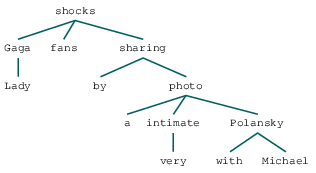

In [169]:
# Using nltk StanfordDependencyParser
from nltk.parse.stanford import StanfordDependencyParser

scp = StanfordDependencyParser(path_to_jar='stanford-parser-full-2018-10-17/stanford-parser.jar', 
                     path_to_models_jar='stanford-parser-full-2018-10-17/stanford-parser-3.9.2-models.jar')

result = list(scp.raw_parse(sentence))

# print the dependency tree
dep_tree = [parse.tree() for parse in result][0]
print(dep_tree)

# visualize raw dependency tree
from IPython.display import display
display(dep_tree)

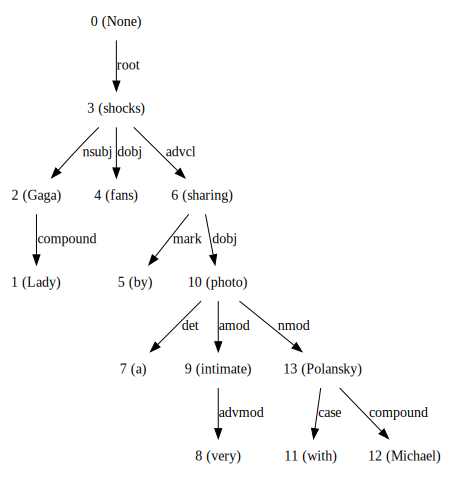

In [170]:
# visualize annotated dependency tree
os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'

from graphviz import Source
dep_tree_dot_repr = [parse for parse in result][0].to_dot()
source = Source(dep_tree_dot_repr, filename="dep_tree", format="png")
source

## Named Entity Recognition (NER)

Typically, a text document will have specific entities that specifically refer to proper nouns like people's names, places, organizations, teams, etc. This technique classifies these entities under predefined classes. `spacy` has some capabilities to do this so let's try it.

In [172]:
sentence = str(news_df.iloc[0].full_text)
sentence_nlp = nlp(sentence)

# print named entities in an article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(Gaga, 'PERSON'), (Michael, 'PERSON'), (Polansky, 'PERSON'), (Gaga, 'PERSON'), (Michael, 'PERSON'), (Polansky, 'PERSON'), (Sunday, 'DATE'), (Super, 'EVENT'), (Bowl, 'EVENT'), (LIV, 'EVENT'), (Miami, 'GPE')]


This is pretty cool.  It picks up all the entities in this doc.

We can now use this to find the most frequently named entities in the news corpus. 

In [174]:
# Create a dataframe of named entities and their type
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

df_entity = pd.DataFrame(named_entities, columns=['Entity Name', 'Entity Type'])
df_entity.head(10)

,Entity Name,Entity Type
0,Gaga,PERSON
1,Michael Polansky,PERSON
2,Gaga,PERSON
3,Michael Polansky,PERSON
4,Sunday Super Bowl LIV Miami,GPE
5,Buffalo Bills,ORG
6,Greg Olsen,PERSON
7,hours Greg Olsen,PERSON
8,Carolina Panthers,ORG
9,Pro Bowl,ORG


In [175]:
# get the top named entities
top_entities = (df_entity.groupby(by=['Entity Name', 'Entity Type']) \
                    .size() \
                    .sort_values(ascending=False) \
                    .reset_index().rename(columns={0: 'Frequency'}))
top_entities.T.iloc[:, :15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,Iowa,first,Monday,Trump,China,one,Apple,Kansas City Chiefs,Senate,Trump,AP,Super Bowl,Republican,Tesla,Democrats
Entity Type,GPE,ORDINAL,DATE,PERSON,GPE,CARDINAL,ORG,ORG,ORG,ORG,ORG,EVENT,NORP,ORG,NORP
Frequency,16,12,8,7,7,7,7,7,6,6,6,6,5,5,5


Look at the top named entities.  This is not surprising given that the Iowa caucuses are today and that the Superbowl was yesterday, and that coronavirus is currently the biggest health news item. 

In [176]:
# get the top named entities
top_entities = (df_entity.groupby(by=['Entity Type']) \
                   .size() \
                   .sort_values(ascending=False) \
                   .reset_index().rename(columns={0: 'Frequency'}))
top_entities.T.iloc[:, :15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,ORG,PERSON,GPE,DATE,CARDINAL,NORP,ORDINAL,EVENT,MONEY,TIME,LOC,PRODUCT,WORK_OF_ART,FAC,LAW
Frequency,185,145,102,63,55,39,15,15,10,8,8,8,7,5,3


We can also use the `StandfordNERTagger` from `nltk`. 

In [178]:
%%time 

from nltk.tag import StanfordNERTagger

java_path = r'C:\Program Files\Java\jdk1.8.0_221\bin\java.exe'
os.environ['JAVAHOME'] = java_path

sn = StanfordNERTagger('stanford-ner-2018-10-16/classifiers/english.all.3class.distsim.crf.ser.gz', 
                     path_to_jar='stanford-ner-2018-10-16/stanford-ner.jar')

# tag named entities
ner_tagged_sentences = [sn.tag(sent.split()) for sent in corpus]

# extract all named entities
named_entities = []
for sentence in ner_tagged_sentences:
    temp_entity_name = ''
    temp_named_entity = None
    for term, tag in sentence:
        if tag != 'O':
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

df_entity = pd.DataFrame(named_entities, columns=['Entity Name', 'Entity Type'])
df_entity.head()

Wall time: 4min 12s


,Entity Name,Entity Type
0,Lady Gaga,PERSON
1,Michael Polansky. Lady Gaga,PERSON
2,Michael Polansky,PERSON
3,Miami,LOCATION
4,Buffalo Bills,ORGANIZATION


In [179]:
# view top entities and types
top_entities = (df_entity.groupby(by=['Entity Name', 'Entity Type']) \
                    .size() \
                    .sort_values(ascending=False) \
                    .reset_index().rename(columns={0: 'Frequency'}))

top_entities.head(15)


,Entity Name,Entity Type,Frequency
0,Iowa,LOCATION,17
1,Trump,PERSON,9
2,Kansas City Chiefs,ORGANIZATION,8
3,Apple,ORGANIZATION,6
4,Senate,ORGANIZATION,6
5,China,LOCATION,5
6,Disney,ORGANIZATION,4
7,U.S.,LOCATION,4
8,Kobe Bryant,PERSON,4
9,Kansas City,LOCATION,4


In [180]:

top_entities = (df_entity.groupby(by=['Entity Type']) \
                   .size() \
                   .sort_values(ascending=False) \
                   .reset_index().rename(columns={0: 'Frequency'}))
top_entities.head()


,Entity Type,Frequency
0,PERSON,137
1,ORGANIZATION,120
2,LOCATION,95


## SENTIMENT ANALYSIS

Since we have unlabeled data, we will use lexicon-based approaches to try to classify our news corpus into sentiments. I'll be using <a href='https://github.com/fnielsen/afinn'>AFINN lexicon</a> and the <a href='https://github.com/sloria/TextBlob/blob/eb08c120d364e908646731d60b4e4c6c1712ff63/textblob/en/en-sentiment.xml'>TextBlob lexicon</a>

### Sentiment Analysis with AFINN

Developed and curated by Finn Årup Nielsen, this is one of the most popular lexicons used for sentiment analysis. There is a nice wrapper library called `afinn` which I'll use here

In [201]:
from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                          else 'neutral' 
                          for score in sentiment_scores]

# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.head()

,news_category,sentiment_score,sentiment_category
0,sports,3.0,positive
1,sports,0.0,neutral
2,sports,2.0,positive
3,sports,1.0,positive
4,sports,-2.0,negative


In [202]:
df.groupby(by=['news_category']).describe()

sentiment_score                                                 
                        count      mean       std   min   25%  50%   75%   max
news_category                                                                 
business                 30.0  1.133333  3.720709  -7.0 -0.75  1.0  2.75  14.0
politics                 30.0 -1.200000  2.929046  -7.0 -3.75  0.0  0.00   4.0
science                  30.0 -1.233333  3.747950 -12.0 -2.75 -0.5  1.00   4.0
sports                   29.0  3.034483  4.917046  -6.0  0.00  2.0  6.00  16.0
technology               30.0  0.500000  3.692957  -7.0 -1.00  1.0  2.00   9.0

Results above are super interesting and not shocking... We are in the biggest bull markets ever and the Superbowl was yesterday, which generally received positive reviews, so it's not surprising that both have positive sentiment scores. Nothing positive is ever reported in the politics in this day and age and the coronavirus may have something to do with the negative science score. 

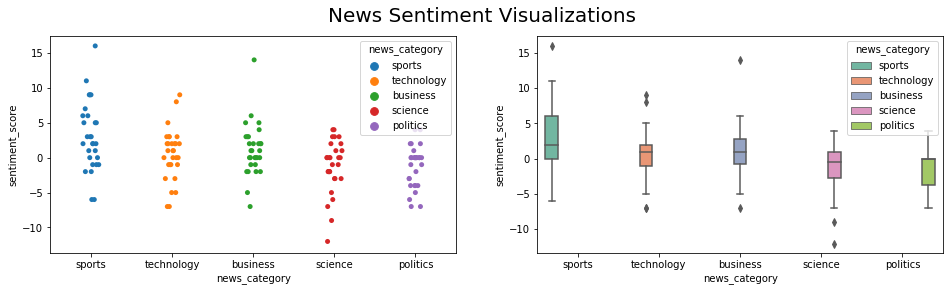

In [203]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sp = sns.stripplot(x='news_category', y='sentiment_score', 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y='sentiment_score', 
                 hue='news_category', data=df, palette='Set2', ax=ax2)
t = f.suptitle('News Sentiment Visualizations', fontsize=20)

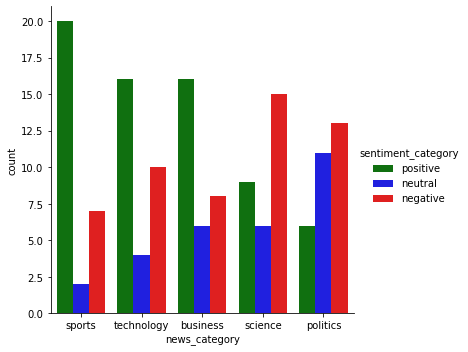

In [204]:
# frequency of sentiment labels
fc = sns.catplot(x="news_category", hue="sentiment_category", 
                 data=df, kind="count",
                 palette={'negative': 'red',
                          'positive': 'green',
                          'neutral': 'blue'})

In [205]:
print('Highest positive sports sentiment score: ', max(df[df.news_category=='sports'].sentiment_score))
print('Lowest negative sports sentiment score: ', min(df[df.news_category=='sports'].sentiment_score))

Highest positive sports sentiment score:  16.0
Lowest negative sports sentiment score:  -6.0


In [206]:
pos_idx = df[(df.news_category=='sports') & (df.sentiment_score == 16)].index[0]
neg_idx = df[(df.news_category=='sports') & (df.sentiment_score == -6)].index[0]

print('Highest positive sports news article: \n', news_df.iloc[pos_idx][['news_article']][0], '\n\n')
print('Lowest negative sports news article: \n', news_df.iloc[neg_idx][['news_article']][0])

Highest positive sports news article: 
  Super Bowl Sunday came and went with the Kansas City Chiefs securing their first Super Bowl championship in 50 years with a 31-20 win over the San … 


Lowest negative sports news article: 
  Jeff Shiffrin, the father of Mikaela Shiffrin, died unexpectedly on Sunday night at age 65, U.S. Ski & Snowboard confirmed. “My family is heartbroken …


In [207]:
print('Highest positive politics sentiment score: ', max(df[df.news_category=='politics'].sentiment_score))
print('Lowest negative politics sentiment score: ', min(df[df.news_category=='politics'].sentiment_score))

Highest positive world news sentiment score:  4.0
Lowest negative world news sentiment score:  -7.0


In [212]:
pos_idx = df[(df.news_category=='politics') & (df.sentiment_score == 4)].index[0]
neg_idx = df[(df.news_category=='politics') & (df.sentiment_score == -7)].index[0]

print('Highest positive politics article: \n', news_df.iloc[pos_idx][['news_article']][0], '\n\n')
print('Lowest negative politics article: \n', news_df.iloc[neg_idx][['news_article']][0])

Highest positive politics article: 
 (CNN) — Early entrance polls show former Vice President Joe Biden, former South Bend, Indiana, Mayor Pete Buttigieg, Sen. Bernie Sanders and Sen. Elizabeth Warren leading with Iowa caucusgoers. Health 


Lowest negative politics article: 
 Washington (CNN) — Republican Sen. Lisa Murkowski of Alaska announced Monday that she "cannot vote to convict" President Donald Trump in the Senate impeachment trial but nevertheless called his actions


### Sentiment Analysis with TextBlob

TextBlob gives both polarity and subjectivity scores. Polarity score is a float between `[-1.0, 1.0]` and the subjectivity is a float within the range of `[0.0, 1.0]` where `0.0` is highly objective and `1.0` is highly subjective. 

In [213]:
from textblob import TextBlob

# computer sentiment scores (polarty) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                          else 'negative' if score < 0 
                          else 'neutral' 
                          for score in sentiment_scores_tb]

# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                              \
                        count      mean       std    min      25%     50%   
news_category                                                               
business                 30.0  0.034700  0.277518 -0.800 -0.01650  0.0675   
politics                 30.0  0.056033  0.166466 -0.267 -0.00750  0.0105   
science                  30.0  0.002300  0.175884 -0.432 -0.03375  0.0085   
sports                   29.0  0.129759  0.221705 -0.500  0.02100  0.1040   
technology               30.0  0.040933  0.273669 -1.000 -0.00750  0.0545   

                               
                   75%    max  
news_category                  
business       0.18550  0.600  
politics       0.13175  0.500  
science        0.11650  0.325  
sports         0.17700  0.800  
technology     0.18850  0.750

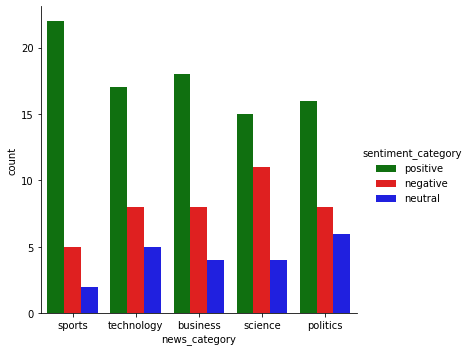

In [214]:
fc = sns.catplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={'negative': 'red',
                             'positive': 'green',
                             'neutral': 'blue'})

Interesting.  This is very different from the previous model.  Here, we have way more positive sentiments even across politics, which is strange. 

In [215]:
print('Highest positive sports sentiment score: ', max(df[df.news_category=='sports'].sentiment_score))
print('Lowest negative sports sentiment score: ', min(df[df.news_category=='sports'].sentiment_score))

Highest positive sports sentiment score:  0.8
Lowest negative sports sentiment score:  -0.5


In [216]:
pos_idx = df[(df.news_category=='sports') & (df.sentiment_score == 0.8)].index[0]
neg_idx = df[(df.news_category=='sports') & (df.sentiment_score == -0.5)].index[0]

print('Highest positive sports news article: \n', news_df.iloc[pos_idx][['news_article']][0], '\n\n')
print('Lowest negative sports news article: \n', news_df.iloc[neg_idx][['news_article']][0])

Highest positive sports news article: 
 KANSAS CITY, Kan. and Mo. — Two cities, two states, one name, separated by a Patrick Mahomes shovel pass. Welcome to Kansas City, Kansas. Wait. (Walks 14 steps.) Kansas City, Missouri! Standing in front 


Lowest negative sports news article: 
 The Toronto Raptors were supposed to be sellers at the trade deadline. That was the prevailing logic on where the franchise would be in February as it entered the season still reckoning with the departure


In [218]:
print('Highest positive politics sentiment score: ', max(df[df.news_category=='politics'].sentiment_score))
print('Lowest negative politics sentiment score: ', min(df[df.news_category=='politics'].sentiment_score))

Highest positive politics sentiment score:  0.5
Lowest negative politics sentiment score:  -0.267


In [220]:
pos_idx = df[(df.news_category=='politics') & (df.sentiment_score == 0.5)].index[0]
neg_idx = df[(df.news_category=='politics') & (df.sentiment_score == -0.267)].index[0]

print('Highest positive politics article: \n', news_df.iloc[pos_idx][['news_article']][0], '\n\n')
print('Lowest negative politics article: \n', news_df.iloc[neg_idx][['news_article']][0])

Highest positive politics article: 
 Democrats pushed to make sure a vote on President Trump's acquittal won't occur until after he delivers his State of the Union address before Congress. Some Donald Trump supporters are peeved the president 


Lowest negative politics article: 
  Television personality Piers Morgan tore into Rep. Adam Schiff for his role in impeaching President Trump. "It was the most absurd, stupid act of …


### Compare results between AFINN and TextBlob

In [247]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, ax, vmax=None,
                          normed=True, title='Confusion matrix',
                          class_names=None, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if normed:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, vmax=vmax, annot=True, square=True, ax=ax, 
                cmap='Blues', cbar=False, linecolor='k',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, fontsize=16)
    if not labels:
        labels=['True Labels', 'Predicted Labels']

    ax.set_ylabel(labels[0], fontsize=12)
    ax.set_xlabel(labels[1], y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

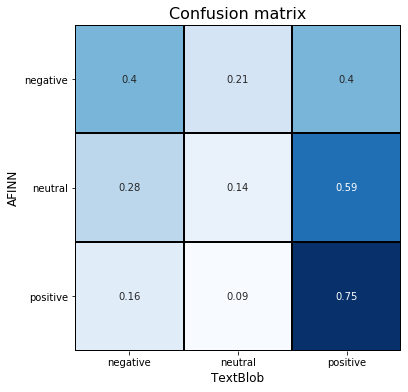

In [250]:
fig, (axis1) = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
plot_confusion_matrix(sentiment_category, sentiment_category_tb, ax=axis1,
                      class_names=['negative', 'neutral', 'positive'],
                      labels=['AFINN', 'TextBlob'])

Seems that AFINN and TextBlob differ significantly on the negative sentiment. TextBlob classifies way more articles as neutral and positive than AFINN. 40% of the articles that AFINN finds negative and ~60% of the articles that AFINN finds as neutral are categorized as positive by TextBlob